In [2]:
# pip install -U scikit-learn scipy matplotlib
# !pip install seaborn
# !pip install statsmodels

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from math import *

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# load Emiliani2 dataset and set date index
dfregion = pd.read_csv("./csv/Emiliani2.csv")
dfregion = dfregion.rename(columns={'Unnamed: 0': 'date'})
dfregion['date'] = pd.to_datetime(dfregion['date'], format='%Y/%m/%d')
dfregion = dfregion.set_index('date')
dfregion = dfregion.asfreq('8D')

meanOfMean = dfregion['mean'].mean()
dfregion['meanAnomaly'] = dfregion['mean'].subtract(meanOfMean)

dfregion.head()

,mean,median,year,week,meanAnomaly
date,,,,,
2001-01-05,0.214281,0.00,2001,1,-0.216162
2001-01-13,0.484737,0.52,2001,2,0.054295
2001-01-21,0.466071,0.47,2001,3,0.035629
2001-01-29,0.417470,0.44,2001,5,-0.012972
2001-02-06,0.492202,0.53,2001,6,0.061760


array([<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>,
       <AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>,
       <AxesSubplot: xlabel='date'>], dtype=object)

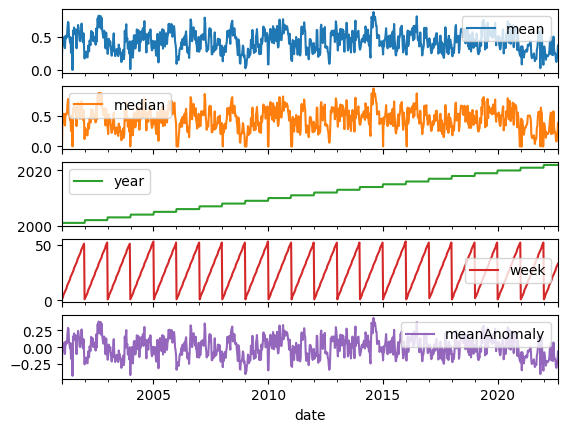

In [8]:
dfregion.plot(subplots=True)

### Regression with incremental index to study mean stationarity

In [3]:
dfregion_regr = pd.read_csv("./csv/Emiliani2.csv")
dfregion_regr = dfregion_regr.rename(columns={'Unnamed: 0': 'date'})
meanOfMean = dfregion_regr['mean'].mean()
dfregion_regr['meanAnomaly'] = dfregion_regr['mean'].subtract(meanOfMean)

In [6]:
y = dfregion_regr['meanAnomaly']
X = dfregion_regr.index.values
X = X.reshape(X.shape[0], 1)

#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X, y)

print('Coefficients: \n', '{:.20f}'.format(regression.coef_[0]), regression.intercept_)

Coefficients: 
 -0.00003035545179255882 0.014980415459627784


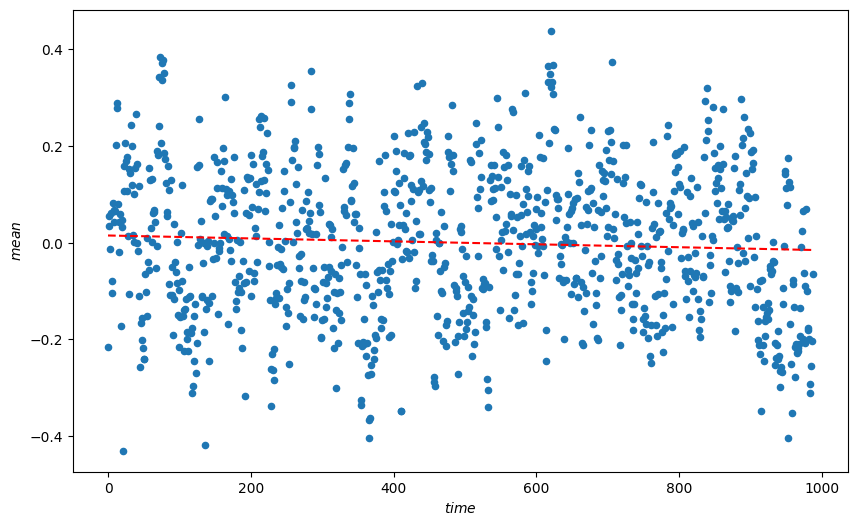

In [7]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(10,6))

# Plot best-fit line
best_fit = regression.intercept_ + regression.coef_[0] * X

ax_scat.scatter(X, y, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')

ax_scat.set_xlabel(r'$time$')
ax_scat.set_ylabel(r'$mean$');

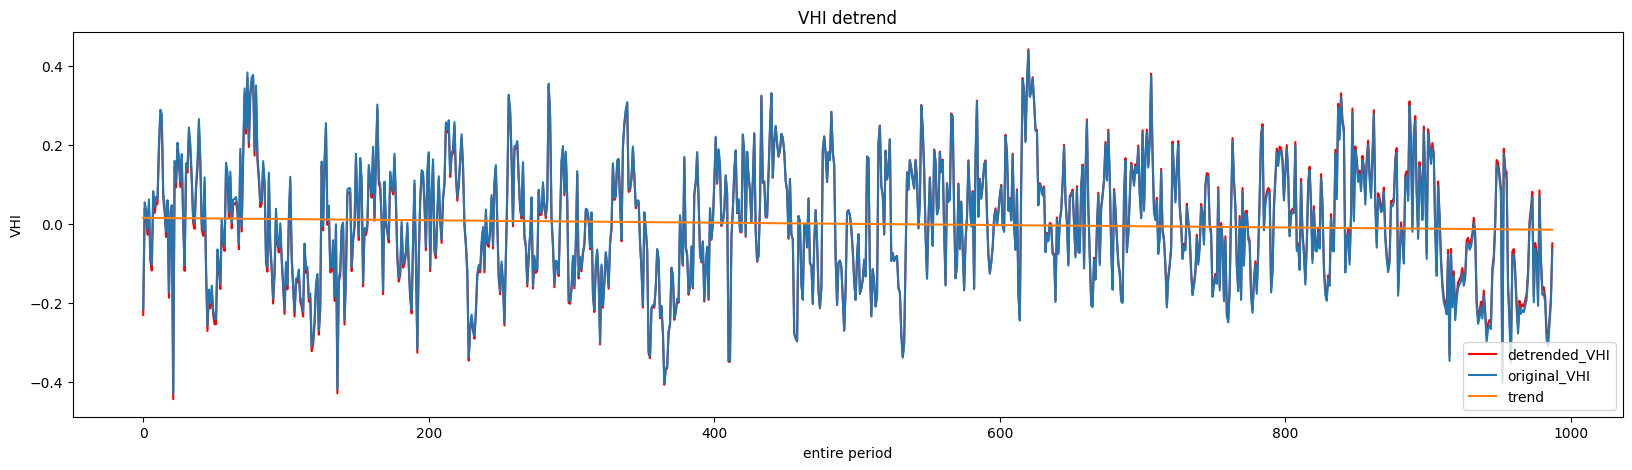

In [10]:
trend = regression.predict(X) # values of the red dotted line (best fit line) above
detrended = [y[i]-trend[i] for i in range(0, len(X))]

plt.plot(detrended, color='red', label = "detrended_VHI")
plt.plot(y, label = "original_VHI")
plt.plot(trend, label ="trend")
plt.rcParams["figure.figsize"] = (20,5)

plt.xlabel("entire period")
plt.ylabel("VHI")
plt.title("VHI detrend")

plt.legend(loc="lower right")

plt.show()

In [10]:
trend.max()

0.014980415459627784

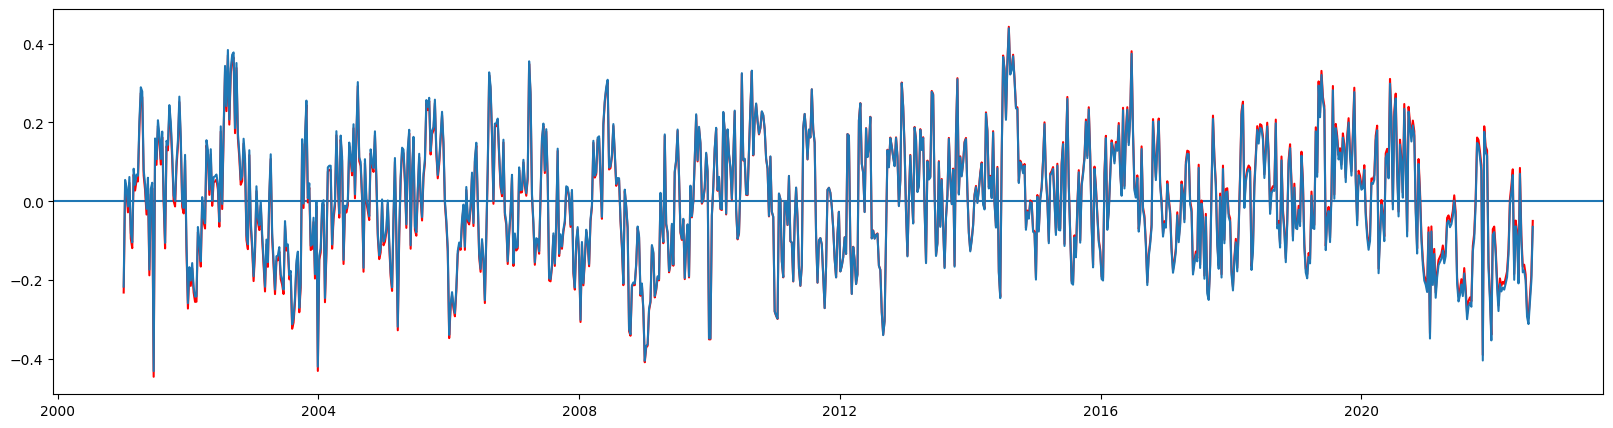

In [14]:
from scipy.signal import detrend

detrended_scipy = detrend(dfregion['meanAnomaly'])

fig,ax= plt.subplots(figsize=(20,5))
ax.axhline(y=0)
ax.plot(dfregion.index,detrended_scipy, color='r')
ax.plot(dfregion.index,dfregion['meanAnomaly'])



#### Augmented Dickey-Fuller test
for stationarity: p_value < 0.05 and test_stat < critical values

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    result = adfuller(timeseries, autolag="AIC")
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [16]:
adf_test(dfregion['meanAnomaly'])

Results of Dickey-Fuller Test:
ADF Statistic: -8.384688
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [17]:
adf_test(detrended_scipy)

Results of Dickey-Fuller Test:
ADF Statistic: -8.414988
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
for stationarity: p_value > 0.05 and test_stat < critical values

In [18]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = '{:.20f}'.format(value)
    print (kpss_output)

In [19]:
kpss_test(dfregion['meanAnomaly'])

Results of KPSS Test:
Test Statistic                         0.137247
p-value                                     0.1
#Lags Used                                 16.0
Critical Value (10%)     0.34699999999999997513
Critical Value (5%)      0.46300000000000002265
Critical Value (2.5%)    0.57399999999999995470
Critical Value (1%)      0.73899999999999999023
dtype: object


/Users/veronica/anaconda3/envs/openeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Detrending by Differencing
Additional observation, not necessary since the model seems stationary

<AxesSubplot: xlabel='date'>

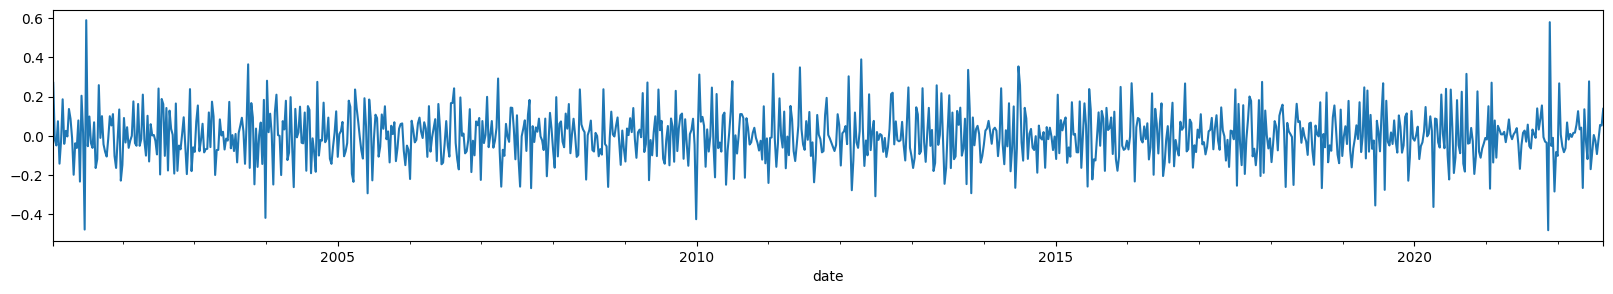

In [21]:
dfregion['mean_diff'] = dfregion['mean'] - dfregion['mean'].shift(1)
dfregion['mean_diff'].dropna().plot(figsize=(20, 3))

In [22]:
adf_test(dfregion['mean_diff'].dropna())
adf_test(detrended_scipy)

Results of Dickey-Fuller Test:
ADF Statistic: -11.611187
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Results of Dickey-Fuller Test:
ADF Statistic: -8.414988
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [24]:
kpss_test(dfregion['mean_diff'].dropna())
kpss_test(dfregion['meanAnomaly'].dropna())

Results of KPSS Test:
Test Statistic                         0.070824
p-value                                     0.1
#Lags Used                                 82.0
Critical Value (10%)     0.34699999999999997513
Critical Value (5%)      0.46300000000000002265
Critical Value (2.5%)    0.57399999999999995470
Critical Value (1%)      0.73899999999999999023
dtype: object
Results of KPSS Test:
Test Statistic                         0.137247
p-value                                     0.1
#Lags Used                                 16.0
Critical Value (10%)     0.34699999999999997513
Critical Value (5%)      0.46300000000000002265
Critical Value (2.5%)    0.57399999999999995470
Critical Value (1%)      0.73899999999999999023
dtype: object


/Users/veronica/anaconda3/envs/openeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/veronica/anaconda3/envs/openeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Regression with incremetal range to study stationarity

In [23]:
dfregion_regr['mean_diff'] = dfregion_regr['mean'] - dfregion_regr['mean'].shift(1)

y = dfregion_regr['mean_diff'].dropna()
X = dfregion_regr.index.values[1:]
X = X.reshape(X.shape[0], 1)

#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X, y)

# predicted_y = regression.predict(test_input)
# r2 = regression.score(test_input, testdf)

print('Coefficients: \n', '{:.20f}'.format(regression.coef_[0]), regression.intercept_)

# before: -0.00003035545179255882 0.4454228163756197

Coefficients: 
 -0.00000173119127870419 0.0010087333447700436


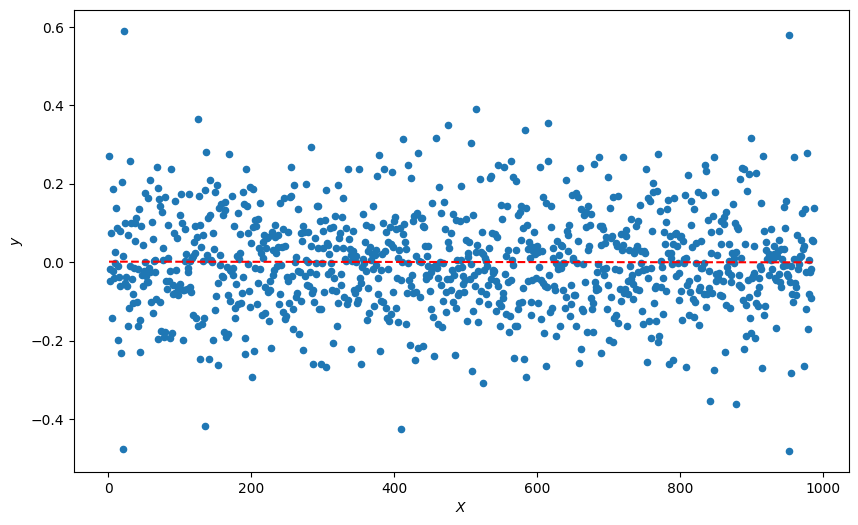

In [24]:
fig_scat, ax_scat = plt.subplots(1,1, figsize=(10,6))

# Plot best-fit line
best_fit = regression.intercept_ + regression.coef_[0] * X

ax_scat.scatter(X, y, s=20, label='Data')
ax_scat.plot(X, best_fit, ls='--', label='Best Fit Line', color='red')

ax_scat.set_xlabel(r'$X$')
ax_scat.set_ylabel(r'$y$');

In [25]:
trend = regression.predict(X)
trend.max()

0.0010070021534913393

### Autoregression of order 1

In [40]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

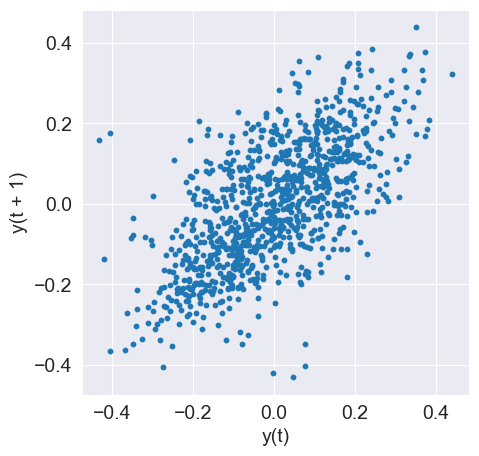

In [41]:
from pandas.plotting import lag_plot

plt.rcParams["figure.figsize"] = (5,5)
lag_plot(dfregion['meanAnomaly'], s=10)
plt.show()

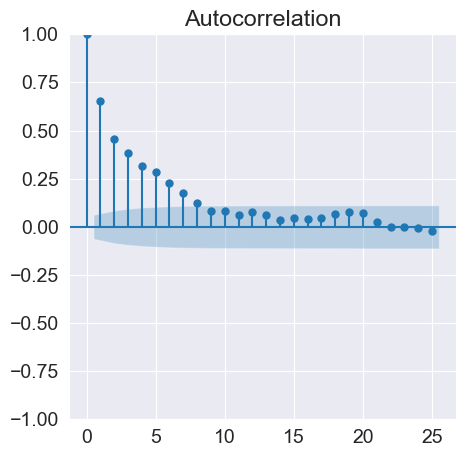

In [42]:
# plot the autocorrelation function + confidence interval of 95%
plot_acf(dfregion['meanAnomaly'], lags = 25, alpha=0.05)
plt.show()

## Autoregression from statsmodels AutoReg

Train dates : 2001-01-05 00:00:00 --- 2018-04-18 00:00:00  (n=790)
Test dates  : 2018-04-26 00:00:00 --- 2022-08-19 00:00:00  (n=198)


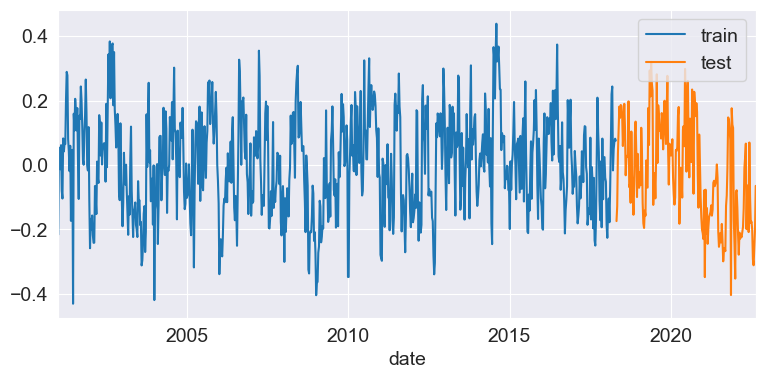

In [45]:
steps = round(len(dfregion)*0.2)
data_train = dfregion[:-steps]
data_test  = dfregion[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['meanAnomaly'].plot(ax=ax, label='train')
data_test['meanAnomaly'].plot(ax=ax, label='test')
ax.legend();

In [46]:
from statsmodels.tsa.stattools import adfuller

# ar1_predictions = ar1_fit.predict(start=len(dfregion)-steps, end=len(dfregion)-1, dynamic = False)

# Here the learned coefficients are used to manually make predictions:
# This requires that the history of n prior observations is kept and that the coefficients used 
# in the regression equation to obtain new forecasts.

def ar_prediction(train, test, window, coef):
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = test.copy()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions[t] = yhat
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    rmse = mean_squared_error(test, predictions)
    print('Test RMSE: %.3f' % rmse)
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

In [103]:
from statsmodels.tsa.ar_model import ar_select_order

# model judged optimal using BIC (Bayesian information criterion)

sel = ar_select_order(dfregion['meanAnomaly'], 13, old_names=False, glob=True)
res = sel.model.fit()
# print(res.summary())
sel.ar_lags

[1, 5]

### Autoregression of order 1

In [51]:
from statsmodels.tsa.ar_model import AutoReg

window = 1

ar1 = AutoReg(data_train['meanAnomaly'], lags = window)
ar1_fit = ar1.fit()
coef = ar1_fit.params
print('Coefficients: %s' % coef)
# print(ar1_fit.summary())

Coefficients: const             0.002375
meanAnomaly.L1    0.651598
dtype: float64


predicted=0.052000, expected=-0.173963
predicted=-0.110979, expected=-0.127332
predicted=-0.080594, expected=0.036375
predicted=0.026077, expected=0.106764
predicted=0.071943, expected=0.181465
predicted=0.120617, expected=0.146501
predicted=0.097835, expected=0.186477
predicted=0.123883, expected=0.183559
predicted=0.121982, expected=0.156078
predicted=0.104075, expected=0.059133
predicted=0.040906, expected=0.122543
predicted=0.082224, expected=0.190062
predicted=0.126219, expected=0.115667
predicted=0.077744, expected=-0.031731
predicted=-0.018300, expected=0.021029
predicted=0.016078, expected=0.028903
predicted=0.021208, expected=0.026476
predicted=0.019627, expected=0.197736
predicted=0.131220, expected=-0.068586
predicted=-0.042315, expected=-0.059077
predicted=-0.036119, expected=-0.117078
predicted=-0.073912, expected=0.104057
predicted=0.070178, expected=-0.030447
predicted=-0.017464, expected=-0.078563
predicted=-0.048816, expected=-0.154301
predicted=-0.098167, expected=-0.

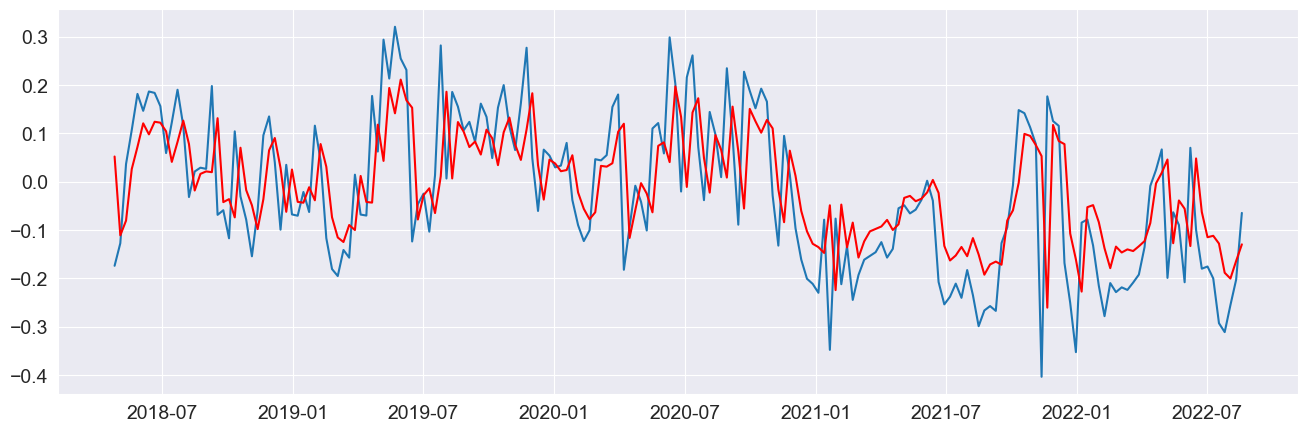

In [52]:
ar_prediction (data_train['meanAnomaly'], data_test['meanAnomaly'], window, coef)

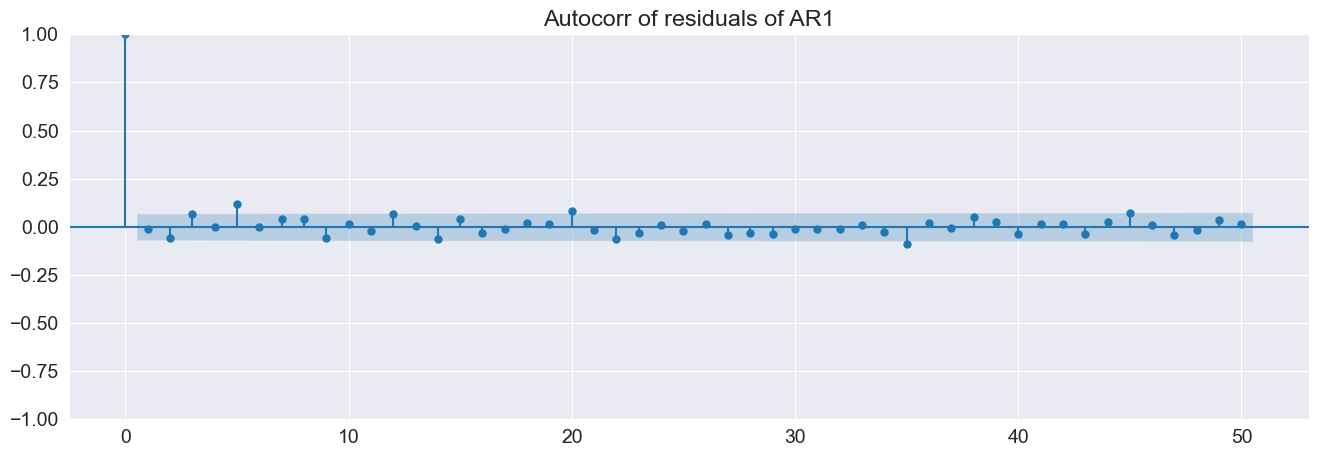

In [50]:
# residuals = real mean anomaly - predicted mean anomaly
# having a good fit for the signal, the residuals should be white noise
residuals_values = ar1_fit.resid.values
sns.mpl.rc("figure", figsize=(16, 5))

plot_acf(residuals_values, lags = 50, alpha=0.05, title = "Autocorr of residuals of AR1")
plt.show()

### Autoregression of order 3

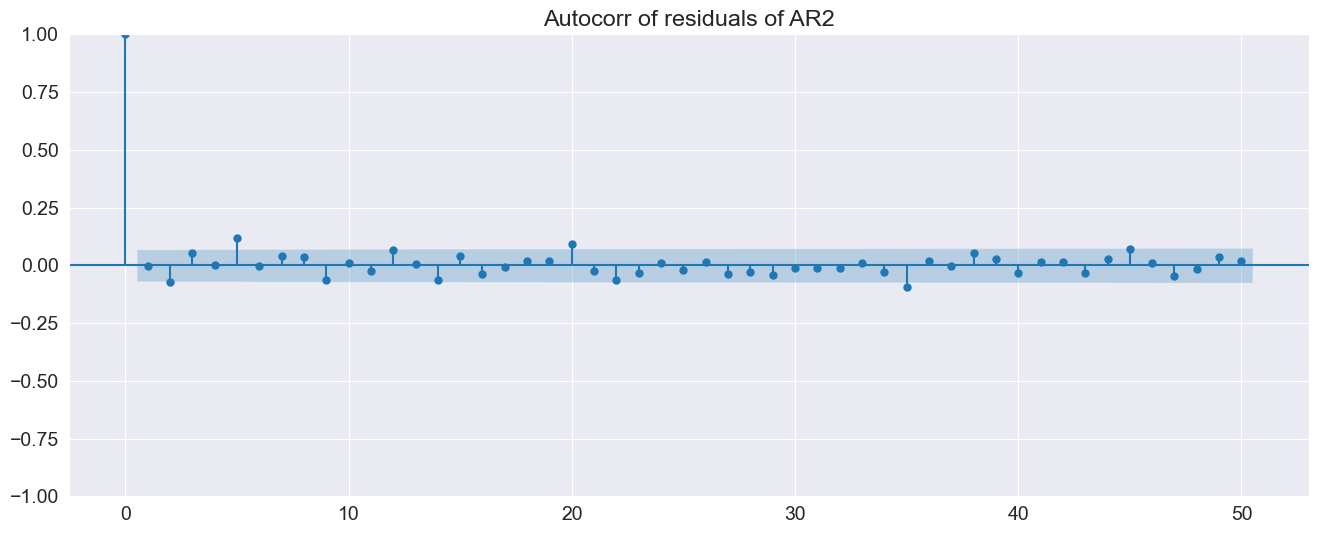

In [156]:
residuals_values = ar2_fit.resid.values

plot_acf(residuals_values, lags = 50, alpha=0.05, title = "Autocorr of residuals of AR2")
plt.show()

In [92]:
window = 3

ar3 = AutoReg(data_train['meanAnomaly'], lags = window)
ar3_fit = ar3.fit()
coef = ar3_fit.params
print('Coefficients: %s' % ar3_fit.params)

Coefficients: const             0.001888
meanAnomaly.L1    0.636871
meanAnomaly.L2   -0.049555
meanAnomaly.L3    0.112610
dtype: float64


predicted=0.054490, expected=0.054490
predicted=0.042034, expected=0.040448
predicted=0.033524, expected=-0.062792
predicted=-0.033971, expected=-0.038085
predicted=-0.014701, expected=0.009992
predicted=0.003068, expected=0.037338
predicted=0.020884, expected=0.078077
predicted=0.050888, expected=0.066320
predicted=0.044461, expected=0.089520
predicted=0.064406, expected=0.084453
predicted=0.058706, expected=0.076076
predicted=0.056234, expected=0.036519
predicted=0.030886, expected=0.063947
predicted=0.049371, expected=0.082805
predicted=0.055567, expected=0.054405
predicted=0.039635, expected=0.000594
predicted=0.008895, expected=0.021789
predicted=0.021862, expected=0.012537
predicted=0.008860, expected=0.015147
predicted=0.013367, expected=0.086874
predicted=0.057876, expected=-0.029354
predicted=-0.019406, expected=-0.004242
predicted=0.010424, expected=-0.048160
predicted=-0.031879, expected=0.046178
predicted=0.033206, expected=-0.021035
predicted=-0.019221, expected=-0.020433


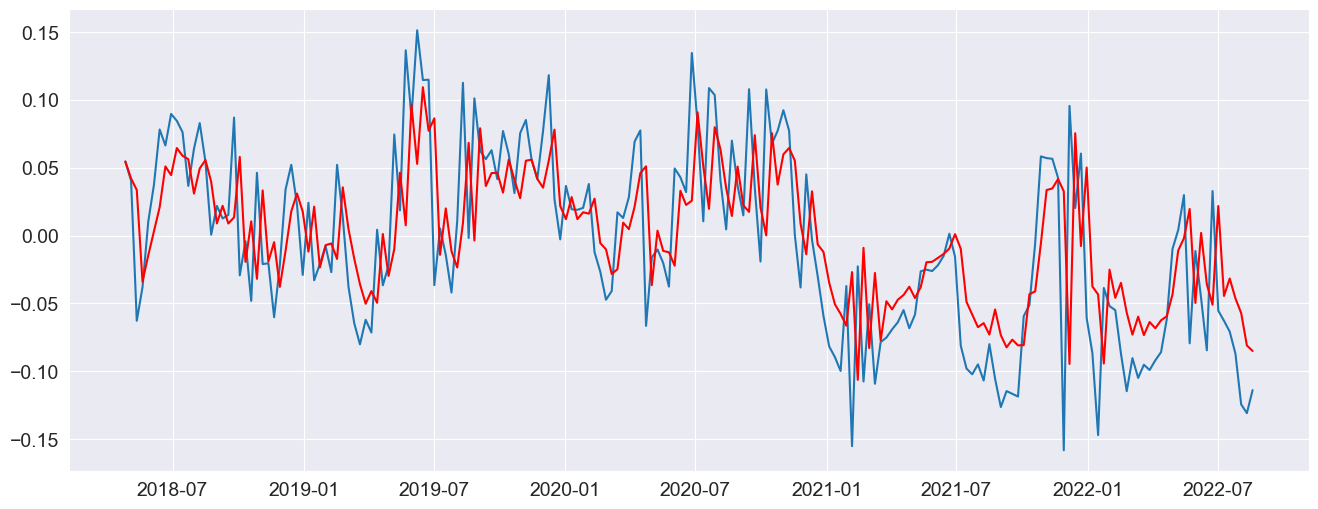

In [93]:
ar_prediction (data_train['meanAnomaly'], data_test['meanAnomaly'], window, coef)

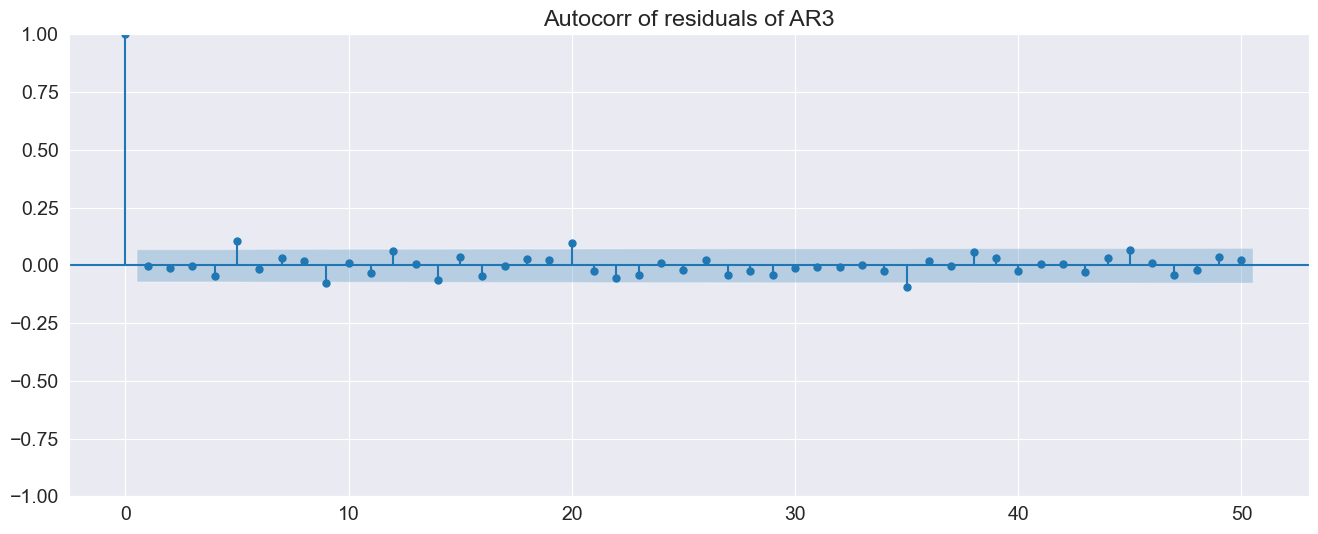

In [157]:
residuals_values = ar3_fit.resid.values

plot_acf(residuals_values, lags = 50, alpha=0.05, title = "Autocorr of residuals of AR3")
plt.show()

### Autoregression of order 5

In [126]:
window = 5

ar5 = AutoReg(data_train['meanAnomaly'], lags = window)
ar5_fit = ar5.fit()
coef = ar5_fit.params
print('Coefficients: %s' % ar5_fit.params)

Coefficients: const             0.001668
meanAnomaly.L1    0.634415
meanAnomaly.L2   -0.058068
meanAnomaly.L3    0.107508
meanAnomaly.L4   -0.041646
meanAnomaly.L5    0.087916
dtype: float64


predicted=0.049492, expected=0.054490
predicted=0.041967, expected=0.040448
predicted=0.035310, expected=-0.062792
predicted=-0.030635, expected=-0.038085
predicted=-0.010073, expected=0.009992
predicted=0.006574, expected=0.037338
predicted=0.026852, expected=0.078077
predicted=0.046173, expected=0.066320
predicted=0.039459, expected=0.089520
predicted=0.062327, expected=0.084453
predicted=0.057209, expected=0.076076
predicted=0.058754, expected=0.036519
predicted=0.031600, expected=0.063947
predicted=0.052648, expected=0.082805
predicted=0.058670, expected=0.054405
predicted=0.043417, expected=0.000594
predicted=0.008335, expected=0.021789
predicted=0.023479, expected=0.012537
predicted=0.013435, expected=0.015147
predicted=0.017650, expected=0.086874
predicted=0.056395, expected=-0.029354
predicted=-0.018977, expected=-0.004242
predicted=0.010492, expected=-0.048160
predicted=-0.034081, expected=0.046178
predicted=0.042164, expected=-0.021035
predicted=-0.021940, expected=-0.020433


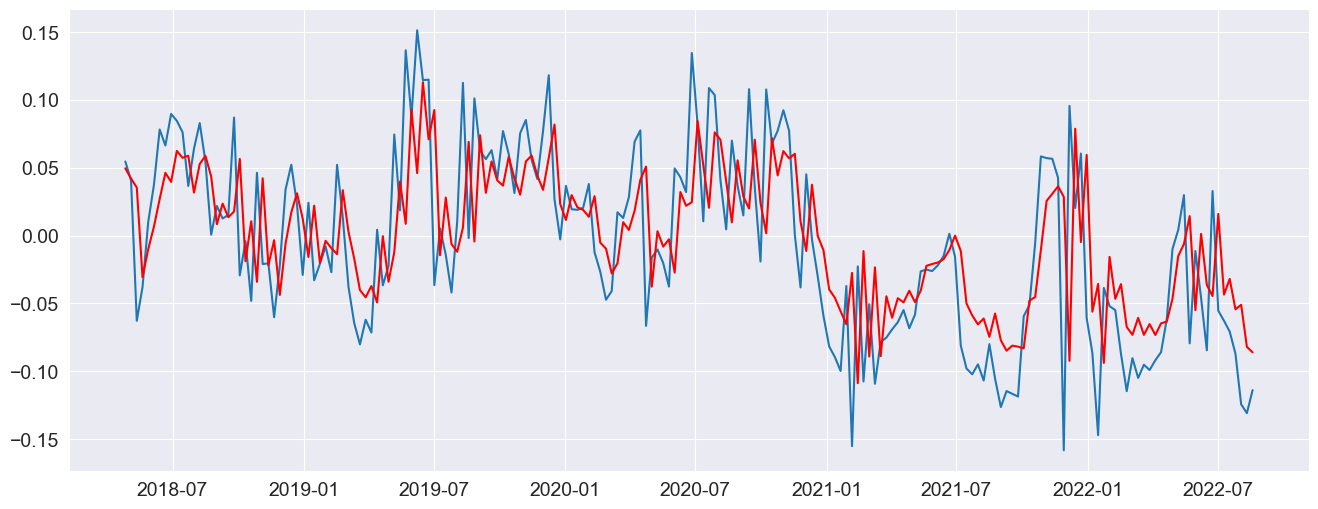

In [127]:
ar_prediction (data_train['meanAnomaly'], data_test['meanAnomaly'], window, coef)

In [ ]:
plot_acf(residuals_values, lags = 50, alpha=0.05, title = "Autocorr of residuals of AR5")
plt.show()

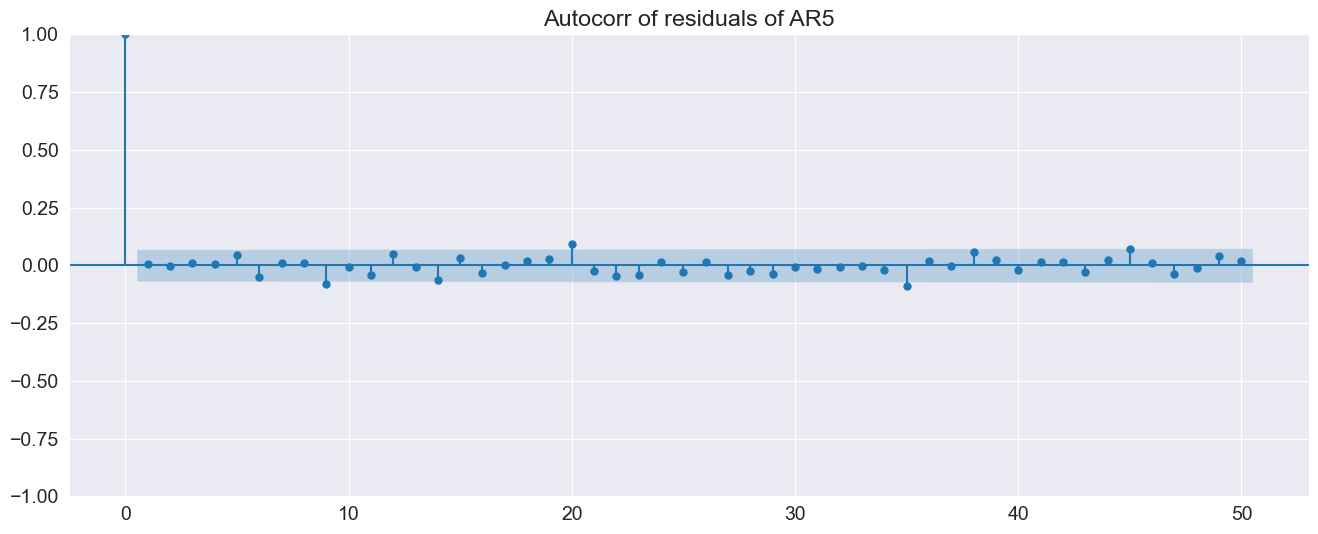

In [158]:
residuals_values = ar5_fit.resid.values

plot_acf(residuals_values, lags = 50, alpha=0.05, title = "Autocorr of residuals of AR5")
plt.show()

### Autoregression of order 20

In [131]:
window = 20

ar20 = AutoReg(data_train['meanAnomaly'], lags = window)
ar20_fit = ar20.fit()
coef = ar20_fit.params
print('Coefficients: %s' % ar20_fit.params)

Coefficients: const              0.001415
meanAnomaly.L1     0.648115
meanAnomaly.L2    -0.072422
meanAnomaly.L3     0.122547
meanAnomaly.L4    -0.042711
meanAnomaly.L5     0.130033
meanAnomaly.L6    -0.075539
meanAnomaly.L7     0.044438
meanAnomaly.L8    -0.012959
meanAnomaly.L9    -0.068811
meanAnomaly.L10    0.030566
meanAnomaly.L11   -0.026466
meanAnomaly.L12    0.075581
meanAnomaly.L13   -0.043724
meanAnomaly.L14   -0.035717
meanAnomaly.L15    0.050993
meanAnomaly.L16   -0.050480
meanAnomaly.L17    0.013175
meanAnomaly.L18    0.014925
meanAnomaly.L19    0.022824
meanAnomaly.L20   -0.000294
dtype: float64


predicted=0.045139, expected=0.054490
predicted=0.052458, expected=0.040448
predicted=0.013604, expected=-0.062792
predicted=-0.037402, expected=-0.038085
predicted=0.002545, expected=0.009992
predicted=-0.001877, expected=0.037338
predicted=0.026446, expected=0.078077
predicted=0.017472, expected=0.066320
predicted=0.037086, expected=0.089520
predicted=0.060773, expected=0.084453
predicted=0.044796, expected=0.076076
predicted=0.075993, expected=0.036519
predicted=0.037461, expected=0.063947
predicted=0.059740, expected=0.082805
predicted=0.049114, expected=0.054405
predicted=0.039746, expected=0.000594
predicted=0.011544, expected=0.021789
predicted=0.022471, expected=0.012537
predicted=0.015655, expected=0.015147
predicted=0.014829, expected=0.086874
predicted=0.055569, expected=-0.029354
predicted=-0.023430, expected=-0.004242
predicted=0.003478, expected=-0.048160
predicted=-0.038261, expected=0.046178
predicted=0.048618, expected=-0.021035
predicted=-0.028358, expected=-0.020433


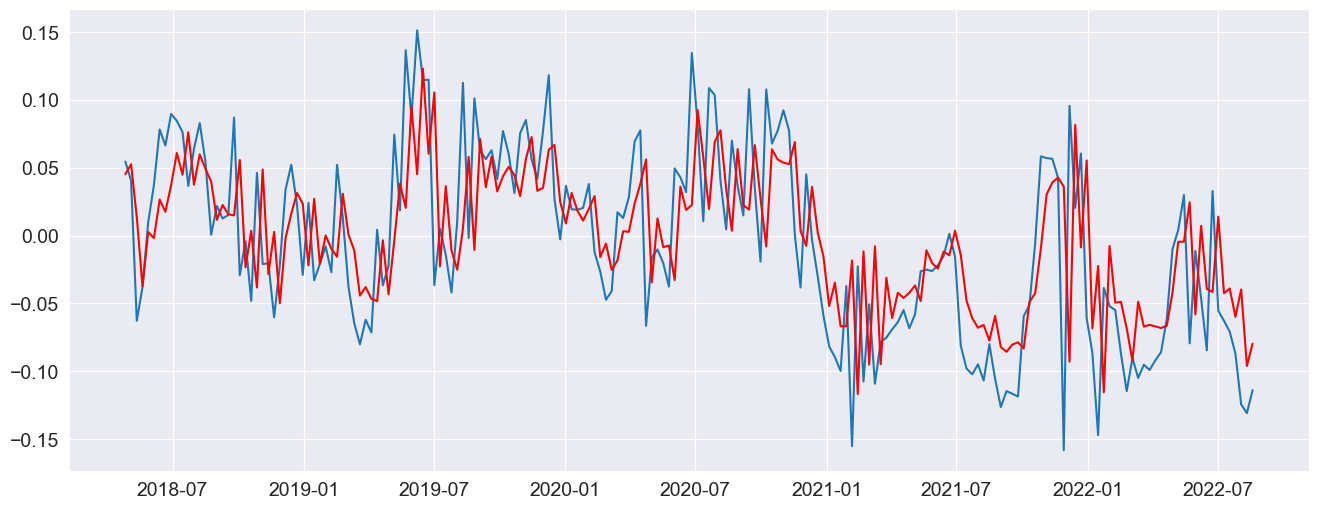

In [132]:
ar_prediction (data_train['meanAnomaly'], data_test['meanAnomaly'], window, coef)

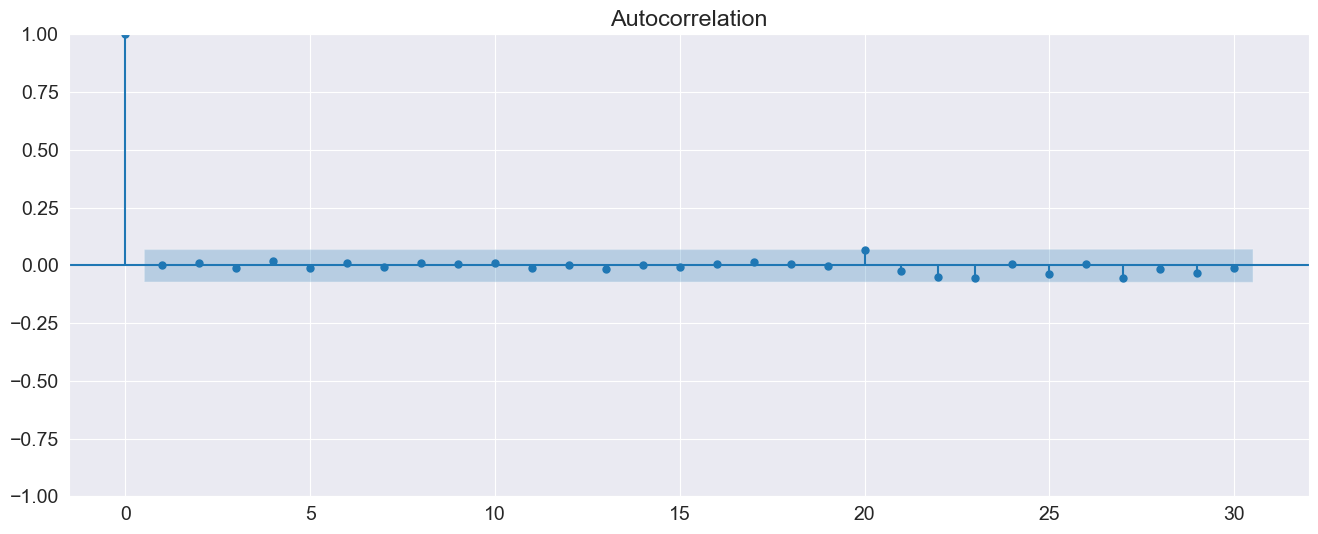

In [133]:
residuals_values = ar20_fit.resid.values

plot_acf(residuals_values, lags = 30, alpha=0.05)
plt.show()

### Autoregression of order 1 with mean differences

In [40]:
from statsmodels.tsa.ar_model import AutoReg

window = 1

ar1_differential = AutoReg(data_train['mean_diff'].dropna(), lags = window)
ar1_differential_fit = ar1_differential.fit()
coef = ar1_differential_fit.params
print('Coefficients: %s' % coef)
# print(ar1_fit.summary())

Coefficients: const           0.000100
mean_diff.L1   -0.190806
dtype: float64


predicted=0.001185, expected=-0.250121
predicted=0.047825, expected=0.046631
predicted=-0.008798, expected=0.163707
predicted=-0.031136, expected=0.070389
predicted=-0.013331, expected=0.074701
predicted=-0.014153, expected=-0.034964
predicted=0.006771, expected=0.039976
predicted=-0.007528, expected=-0.002918
predicted=0.000657, expected=-0.027482
predicted=0.005344, expected=-0.096945
predicted=0.018598, expected=0.063411
predicted=-0.011999, expected=0.067518
predicted=-0.012783, expected=-0.074395
predicted=0.014295, expected=-0.147398
predicted=0.028224, expected=0.052760
predicted=-0.009967, expected=0.007873
predicted=-0.001402, expected=-0.002427
predicted=0.000563, expected=0.171260
predicted=-0.032578, expected=-0.266322
predicted=0.050916, expected=0.009509
predicted=-0.001715, expected=-0.058001
predicted=0.011167, expected=0.221134
predicted=-0.042094, expected=-0.134504
predicted=0.025764, expected=-0.048116
predicted=0.009281, expected=-0.075738
predicted=0.014551, expec

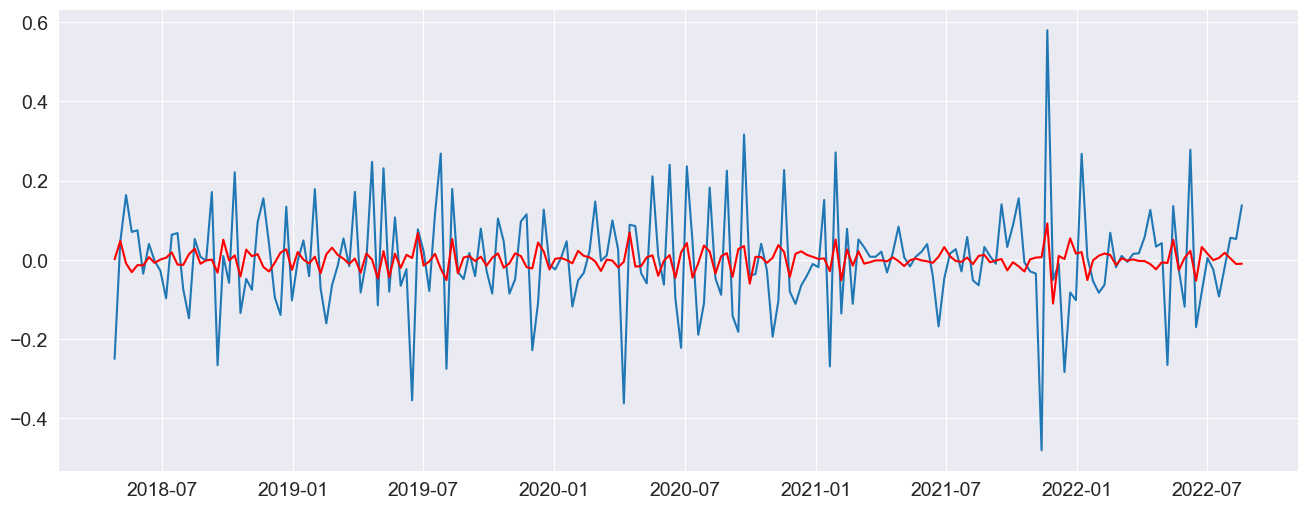

In [46]:
ar_prediction (data_train['mean_diff'], data_test['mean_diff'], window, coef)

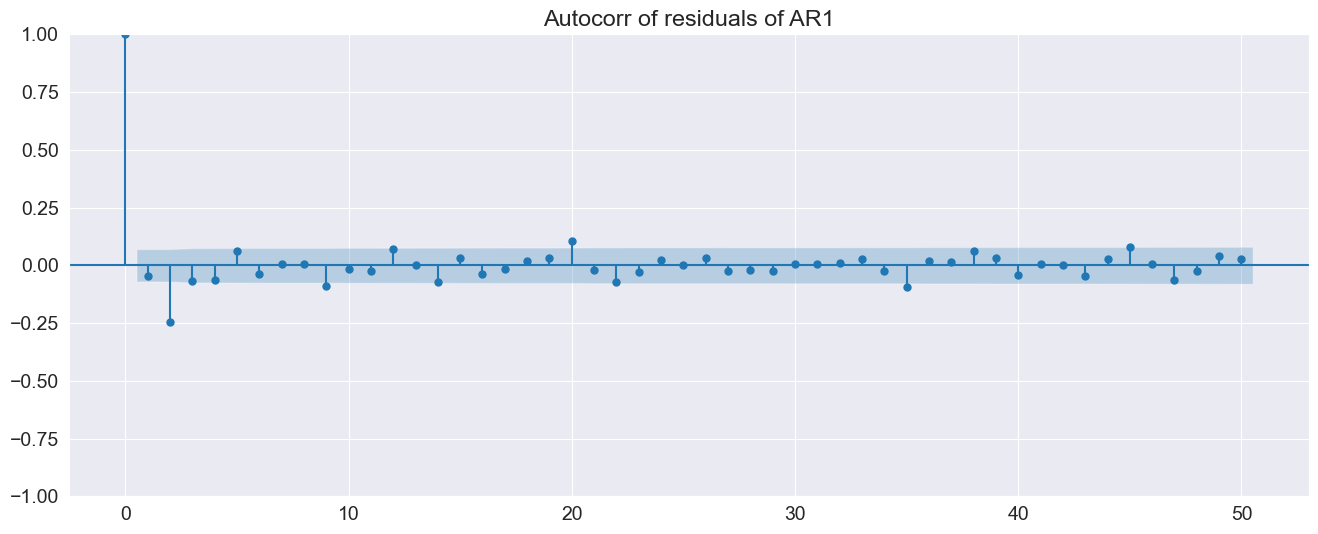

In [48]:
residuals_values = ar1_differential_fit.resid.values

plot_acf(residuals_values, lags = 50, alpha=0.05, title = "Autocorr of residuals of AR1")
plt.show()

### Ljung-Box test 
Statistical test that checks if autocorrelation exists in a time series.  
It uses the following hypotheses:  
H0: The residuals are independently distributed.  
HA: The residuals are not independently distributed; they exhibit serial correlation.  
p-value of the test should be greater than 0.05 to fail to reject the null hypothesis (residuals for time series model are independent)

In [142]:
sm.stats.acorr_ljungbox(ar1_fit.resid, lags=1)

,lb_stat,lb_pvalue
1,0.116787,0.732545


In [143]:
sm.stats.acorr_ljungbox(ar2_fit.resid, lags=2)

,lb_stat,lb_pvalue
1,0.005301,0.941959
2,4.288340,0.117165


In [144]:
sm.stats.acorr_ljungbox(ar3_fit.resid, lags=3)

,lb_stat,lb_pvalue
1,0.001573,0.968366
2,0.081542,0.960049
3,0.092603,0.992710


In [47]:
sm.stats.acorr_ljungbox(ar1_differential_fit.resid, lags=1)

,lb_stat,lb_pvalue
1,1.703703,0.191804
